In [1]:
%pylab inline
#import matplotlib as plt
#import numpy as np
import pandas as pd
import uncertainties
from uncertainties import unumpy as unp
from uncertainties import ufloat
from sympy import *
from numpy import array as array

def gaussian(x, mu, sigma, B, A):
    return A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)) + B

def gausfit_pm(x, y, p0=None):
    import numpy as np
    return fit_pm(x, y, func=lambda x, mu, sigma, B, A: A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)) + B,
                  p0=p0)
def sine(x,a,b,c,d):
    import numpy as np
    return a*np.sin(c*x-d)+b

def sinefit_pm(x,y,p0=None):
    return fit_pm(x,y,sine,p0=p0)

def line(x,a,b):
    return a * x + b

def linfit_pm(x, y, p0=None):
    return fit_pm(x, y, func=lambda x, a, b,: a * x + b, p0=p0)


def fit_pm(x, y, func=lambda x: x, p0=None):
    """
        fit_pm takes data points and makes an exponential curve fit. It returns
        the parameters with errors and the coefficient of determination
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: Function to be fitted to.
        Returns:
        -----------
        list: Gives back a list with the parameters of an expotential function the
              corresponding errors and the coefficient of determination.
    """
    from scipy.optimize import curve_fit
    import numpy as np
    popt, pcov = curve_fit(func, x, y, p0=p0)
    params = popt.copy()
    errors = np.sqrt(np.diag(pcov))
    r = np.array(y) - func(np.array(x), *params)
    rss = np.sum(r ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    R_2 = 1 - (rss / tss)
    try:
        from uncertainties import unumpy as unp
        return unp.uarray(params, errors), R_2
    except:
        return np.array(params), np.array(errors), R_2


def val(x):
    from uncertainties import unumpy
    try:
        return unumpy.nominal_values(x)
    except TypeError:
        return x


def err(x):
    from uncertainties import unumpy
    return unumpy.std_devs(x)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size
#plt.plot(x,y,"x")

Populating the interactive namespace from numpy and matplotlib


In [2]:
%store -r cali
%store -r upper_bound
%store -r lower_bound
print("cali\n",cali)
print("bounds")
print(upper_bound,lower_bound)

cali
 [-0.0004498044862935331+/-1.2337559572759262e-05
 19.165789913327547+/-0.0076259371949722755]
bounds
0.04733+/-0.00015 -0.01105+/-0.00015


In [18]:
def to_freq(x):
    return line(x,*cali)

In [3]:
#filenames = ["dx_1.csv","dx_2.csv","dx_3.csv","dx_4.csv","dx_5.csv"]
filename_l,filename_r = "guess_",".csv"
#data = [[a_ch1,a_ch2],[b_ch1,b_ch2],[c_ch1,c_ch2],[d_ch1,d_ch2],[e_ch1,e_ch2]]
data= []
for i in range(2,8):
    df = pd.read_csv(filename_l+str(i)+filename_r,index_col=0)
    data.append([array([float(item) for item in df.iloc[1:,0].to_numpy()],
                      dtype=float64),array([float(item) for item in df.iloc[1:,1].to_numpy()],dtype=float64)])

# automatic fits

In [12]:
data_sine = data[0][0]
data_dip = data[0][1]

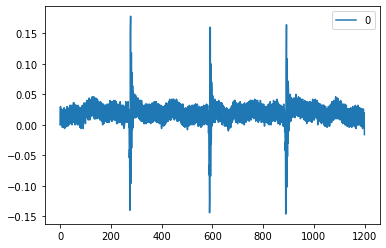

In [13]:
x = np.arange(len(data_sine))
plt.plot(x,data_sine,label=0)
#plt.plot(x,data_dip,label=1)
plt.legend()
plt.show()

# komponente 1: nullstellen der sinus anregung
fit nötig wegen rauschen
nullstellen numerisch weil einfacher-> höhere präzession?

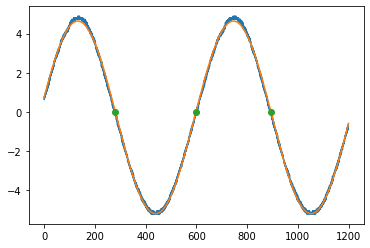

In [14]:
def siner(x,y):
    guess = [max(y),mean(y),100**-1,1]
    params,errs = sinefit_pm(x,y,p0=guess)
    return params,errs

def nuller(x,y,prec=0.01):
    iterator = 0
    nullstellen = [[],[]]
    last = 0
    for item in y:
        if abs(item)<=prec:
            if not abs(x[iterator]-last)<=5:
                nullstellen[0].append(x[iterator])
                nullstellen[1].append(y[iterator])
            last=x[iterator]
        iterator += 1
   
    return nullstellen

x = np.arange(len(data_sine))
x_fine = np.linspace(0,len(data_sine),8*len(data_sine))
y = data_dip
params,err = siner(x,y)

y_guess = val(sine(x_fine,*val(params)))

nullstellen = nuller(x_fine,y_guess)
plt.plot(x,data_dip,label=1)
plt.plot(x_fine,sine(x_fine,*val(params)))
plt.plot(*nullstellen,"o")

In [15]:
[int((item)) for item in nullstellen[0]]

[280, 598, 893]

# datenreihe: Dips um die Nullstellen

In [16]:
ranges=[] 
for item in nullstellen[0]:
    datapoints = data_sine[int(item)-20:int(item)+20]
    #print(item)
    #print(datapoints)
    ranges.append([x[int(item)-20:int(item)+20],datapoints])
#print("\nranges\n\n",ranges)

In [17]:
discr = []
for dataset in ranges:
    intern = []
    for i in range(len(dataset[1])):
        if dataset[1][i] < lower_bound:
            intern.append(i)
#    print(intern)
    stop = 0
    for i in range(len(intern)):
        if i > 1:
            if abs(intern[i]-intern[i-1]) > 2:
                stop = i
                break
    intern = intern[:stop]
    output = [[],[]]
    for num in intern:
        output[0].append(dataset[0][num])
        output[1].append(dataset[1][num])
    discr.append(output)
#    print(output)
#print(discr)

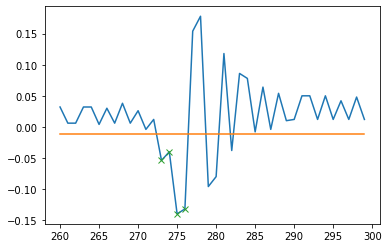

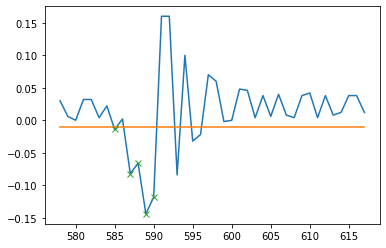

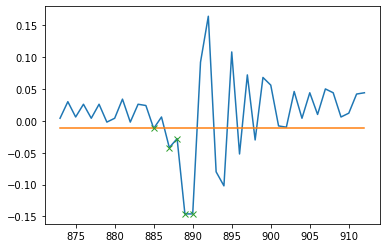

In [10]:
for i in range(3):
    plt.plot(*ranges[i],"-")
    plt.plot(ranges[i][0],np.ones(len(ranges[i][0]))*val(lower_bound),"-")
    plt.plot(discr[i][0],discr[i][1],"x")
    plt.show()

# bestimmung von dip und error

In [30]:
dips = []
for item in discr:
    dip_y = min(item[1])
    dip_x = item[0][item[1].index(dip_y)]
    dip_err = abs(item[0][0]-item[0][-1])
    combi = ufloat(dip_x,dip_err)
    dips.append(combi)

# bestimmung von unterschied nullstelle dip

In [38]:
nst = nullstellen[0]
diffs = []
for i in range(len(nst)):
    intern = dips[i]-nst[i]
    diffs.append(intern)
freq_unterschied = mean(diffs)
freq_unterschied

-6.478209535715545+/-2.5603819159562025

In [37]:
end_freq = to_freq(dips[0]-freq_unterschied)
end_freq

19.03917975188451+/-0.008494013105352574